## Introduction

Youtube is one of the most popular video sharing platform with more than 1 billion users. Users have long been outraged by the overwhelming number of spam messages in the comment section. In 2012 users created a petition asking Youtube to provide tools to deal with undesired content. In 2013, spam problem gets worse as Google overhauled the YouTube comment system to connect it to Google+, which allows users to post links. This attracts more malicious users to self-promote their videos using the platform. This project will build a spam filter to automatically filter spam comments.



## Data Wrangling

In this part we will:

    1: load the data into notebook
    2: check for any missing values

In [1]:

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as py
import seaborn as sns
import numpy as np
import glob 
import re

In [2]:
# import the files

path =r'./data/' 
allSongs = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_songs= []

for file in allSongs:
    frame = pd.read_csv(file)
    frame['song']=re.search(r"-(.*?).csv", file).group(1)
    list_songs.append(frame)
    
df = pd.concat(list_songs)
df.head()


,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,song
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,Psy
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,Psy
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,Psy
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,Psy
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,Psy


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 6 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1711 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
song          1956 non-null object
dtypes: int64(1), object(5)
memory usage: 107.0+ KB


In [4]:
df['DATE']=df['DATE'].fillna(method='ffill')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 369
Data columns (total 6 columns):
COMMENT_ID    1956 non-null object
AUTHOR        1956 non-null object
DATE          1956 non-null object
CONTENT       1956 non-null object
CLASS         1956 non-null int64
song          1956 non-null object
dtypes: int64(1), object(5)
memory usage: 107.0+ KB


In [5]:
df['DATE']=pd.to_datetime(df['DATE'])
df=df.set_index('DATE')
df.head()

,COMMENT_ID,AUTHOR,CONTENT,CLASS,song
DATE,,,,,
2013-11-07 06:20:48,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,Psy
2013-11-07 12:37:15,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,Hey guys check out my new channel and our firs...,1,Psy
2013-11-08 17:34:21,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,just for test I have to say murdev.com,1,Psy
2013-11-09 08:28:43,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,Psy
2013-11-10 16:05:38,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,Psy


In [6]:
df.groupby('CLASS').size()

CLASS
0     951
1    1005
dtype: int64


There are total of 1956 comments in this data for the 5 most popular songs. 951 hams and 1005 spams. There are some missing values in the column of date, since the comments appear sequentially in time, we can use either forward fill or backward fill to estimate the time when that comment is made. The CLASS section is the label: 1 means spam and 0 means ham. 


## Data Analysis

We start the data analysis by asking some basic questions on the dataset:

    *is the average length of comment different among ham and spam?
    *can we identify some suspicious user account that seems relate to spam?
    *are spam comments more likely to have a URL in them?
    *does the spam comments have any correlation with time? (if it's fake account, maybe it's setup to send out spam comments periodically.)


In [7]:
# check the length of the comment.

# first expand contractions, so aren't will be are not so it's counted as two words.

import contractions

def contraction_expand(text):
    return contractions.fix(text)

df['CONTENT']=df['CONTENT'].apply(contraction_expand)

In [8]:

#calculate sentence length

df['length']=df['CONTENT'].apply(len)

df.groupby('CLASS')['length'].agg(['mean','std','min','max'])

,mean,std,min,max
CLASS,,,,
0,49.827550,56.526731,2,755
1,137.769154,159.459172,10,1200


Text(0,0.5,'counts')

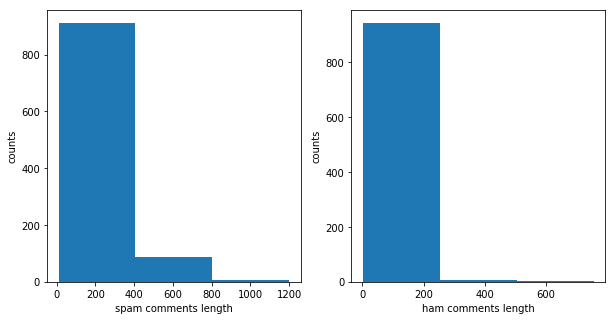

In [9]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.hist(df[df['CLASS']==1].length,bins=3)
ax1.set_xlabel('spam comments length')
ax1.set_ylabel('counts')
ax2.hist(df[df['CLASS']==0].length,bins=3)
ax2.set_xlabel('ham comments length')
ax2.set_ylabel('counts')

The average length of spam vs ham comments are different. T- test shows that the mean comment length is significantly different. i.e. there is significant difference in the comment length b/t spam and ham group.

In [10]:
from scipy import stats

spam_len=df[df.CLASS==1].length.values
ham_len=df[df.CLASS==0].length.values
stats.ttest_ind(spam_len,ham_len,equal_var=False)

Ttest_indResult(statistic=16.426744907451987, pvalue=4.122869768320902e-55)

In [11]:
## check if there contains URL
## some Youtube URL format contains watch? 

def URL (string):
    pattern=r'(http[s]?://*)|(watch?)'
    return (bool(re.search(pattern,string)))

df['URL']=df['CONTENT'].apply(URL)
sum(df['URL'])/len(df['URL'])


0.14008179959100203

In [12]:

URL_dist=df.groupby('CLASS')['URL'].agg(sum)
URL_dist

CLASS
0     40.0
1    234.0
Name: URL, dtype: float64

about 14% of the comments contains URL, and most URLs are found in spam comments.

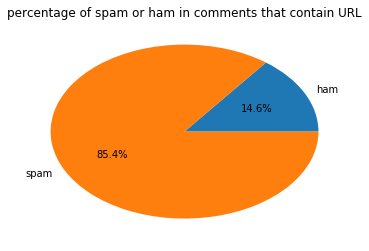

In [13]:
plt.pie(URL_dist/sum(URL_dist), labels=['ham','spam'],autopct='%1.1f%%')
plt.title('percentage of spam or ham in comments that contain URL')
py.savefig('URL.png')

In [14]:
spam_URL=df[df.CLASS==1].URL.values
ham_URL=df[df.CLASS==0].URL.values
stats.ttest_ind(spam_URL,ham_URL,equal_var=False)

Ttest_indResult(statistic=12.852571787339825, pvalue=6.927492725072384e-36)

the number of URLs in ham group is significantly different from the number of URLs in spam group.

In [15]:
# calculate percentage of capital letters in a comment

def capital_letters(string):
    return (len(re.findall('[A-Z]',string))/len(string))

df['capital']=df['CONTENT'].apply(capital_letters)
df['capital'].head()

DATE
2013-11-07 06:20:48    0.017857
2013-11-07 12:37:15    0.119760
2013-11-08 17:34:21    0.026316
2013-11-09 08:28:43    0.000000
2013-11-10 16:05:38    0.153846
Name: capital, dtype: float64

In [16]:
df.groupby('CLASS')['capital'].agg(['mean','std','min','max'])

,mean,std,min,max
CLASS,,,,
0,0.090289,0.161128,0.0,1.000000
1,0.108451,0.173301,0.0,0.919355


In [17]:
spam_C=df[df.CLASS==1].capital.values
ham_C=df[df.CLASS==0].capital.values
stats.ttest_ind(spam_C,ham_C,equal_var=False)

Ttest_indResult(statistic=2.4017292882621466, pvalue=0.016410664509908555)

The number of capital letters adjusted to comment length is significantly different in spam and ham group (assume 95% confidence).

In [18]:
df.groupby('CLASS')['AUTHOR'].value_counts()

CLASS  AUTHOR               
0      5000palo                 7
       Marshmallow Kingdom      3
       Seth Ryan                3
       Alain Bruno              2
       Athena Gomez             2
       BigBird Larry            2
       Brian Brai               2
       Chris Madzier            2
       D Maw                    2
       Eric Gonzalez            2
       Juan Martinez            2
       LaiLa Steudle            2
       LiveLikeLien x           2
       Naga Berapi              2
       Paul Crowder             2
       Pepe The Meme King       2
       Sonny Carter             2
       The Technology Zoo       2
       Warcorpse666             2
       janet rangel             2
       lol Ippocastano          2
       tyler sleetway           2
          Berty  Winata         1
       Aarjav Parmar            1
       Abdinasir Omar           1
       Abdou Abdou              1
       Abdullah Alawani         1
       Abhi Vats                1
       Abhishek Kum

We have 1793 unique user names in this dataset. There is a small fraction of users who make multiple comments but all of users who created spams only combment once. It's noticed that some spam accounts are from foreign countries (since their names are not English character). Next we will see how many foreign user names for spam and ham group.

In [19]:
# how many of non_english characters in the username

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True
    
df['user_isEnglish']=df['AUTHOR'].apply(isEnglish)
df.groupby('CLASS')['user_isEnglish'].value_counts()

CLASS  user_isEnglish
0      True              901
       False              50
1      True              956
       False              49
Name: user_isEnglish, dtype: int64

In [20]:
spam_English=df[df.CLASS==1].user_isEnglish.values
ham_English=df[df.CLASS==0].user_isEnglish.values
stats.ttest_ind(spam_English,ham_English,equal_var=False)

Ttest_indResult(statistic=0.38464960723011715, pvalue=0.7005392401940488)

The number of foreign user names are not significantly different among ham/spam groups.

In [21]:
df[(df['CLASS']==1) & (df['user_isEnglish']==False)]['AUTHOR']

DATE
2014-11-03 21:38:17.000                              Никита Безухов
2014-11-03 22:22:14.000                            Михаил Панкратов
2014-11-03 23:29:00.000                                   Олег Пась
2014-11-06 22:40:49.000                                 David Boček
2014-11-07 12:08:13.000                              Uroš Slemenjak
2014-11-07 17:06:48.000                          O sábio das 7 eras
2014-11-13 07:59:33.000                           Александр Федоров
2014-11-13 21:48:26.000                               Tofik Miedzyń
2014-08-16 07:24:50.000                               Cléda Dimitri
2014-08-28 03:53:35.000                                  Mai Nguyễn
2014-09-10 01:50:55.000                                Nicolás Jara
2014-09-10 21:38:12.000                               Mättr Valleni
2014-10-03 15:28:05.000                     Mehmet Ertuğrul Tohumcu
2014-10-24 09:55:30.000                                احمد الهوارى
2014-11-01 02:37:29.000                    

There is not much suspecious account we can see by looking at ethenity groups from user names. 

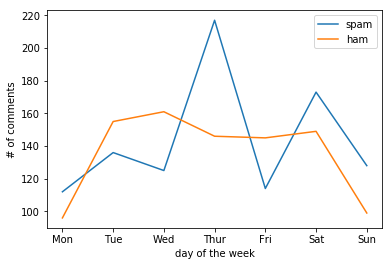

In [22]:

# explore the distribution of # of spam/ham among hours and day of week

spam=df[df['CLASS']==1]
ham=df[df['CLASS']==0]

spam_by_weekday=spam.groupby(spam.index.dayofweek).size()
ham_by_weekday=ham.groupby(ham.index.dayofweek).size()

spam_by_weekday.plot(label='spam')
ham_by_weekday.plot(label='ham')
plt.xticks(np.arange(7),('Mon','Tue','Wed','Thur','Fri','Sat','Sun'))
plt.xlabel('day of the week')
plt.ylabel('# of comments')
plt.legend(loc='upper right')
py.savefig('weekday_trend.png')

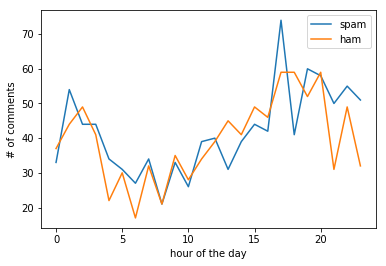

In [23]:
spam_by_hour=spam.groupby(spam.index.hour).size()
ham_by_hour=ham.groupby(ham.index.hour).size()

spam_by_hour.plot(label='spam')
ham_by_hour.plot(label='ham')
plt.xlabel('hour of the day')
plt.ylabel('# of comments')
plt.legend(loc='upper right')
py.savefig('hourly_trend.png')

These two graphs show interesting user behaviour. As we expected, users tend to make more comments in late afternoon throughout the night. We see most spam and ham comments are made b/t 5pm to 1 or 2am. Less comments are made on Sunday and Monday. Probably due to people are busy to start their new week (prep food for kids, run errands etc) and spend less time online. While ham comments are made evenly throughout the rest of week (Tuesday to Saturday), spam comments spike on Thursday and shows some zigzag behavior. There could be a lot of reasons. One explaination could be that spam accounts are programmed to send out spam comments periodically so they are more clustered around certain time.

In [24]:
df['Thursday']=df.index.dayofweek==3

spam_T=df[df.CLASS==1].Thursday.values
ham_T=df[df.CLASS==0].Thursday.values
stats.ttest_ind(spam_T,ham_T,equal_var=False)

Ttest_indResult(statistic=3.5704450654604205, pvalue=0.00036503763138973495)

Whether a comment is made on Thursday is a significant feature that is different in spam/ham group.

### Dimensionality reduction analysis

It will be interesting to see if there is any patterns in the ham/spam group. In this subsection, we will visualize the dataset in lower dimension using t-SNE. t-SNE a non-linear dimensionality reduction algorithm finds patterns in the data by identifying observed clusters based on similarity of data points with multiple features. It's very computational demanding so we first use TruncatedSVD to reduce the feature dimensions. t-SNE recommends limit input size to 50 features, it's seen that after SVD we are able to retain 63% variance in the original data by limiting features to 50.

In [25]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fengyingdeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fengyingdeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
# data cleanning:
# Split into tokens.
# Convert to lowercase.
# Remove punctuation from each token.
# Filter out remaining tokens that are not alphabetic.
# Filter out tokens that are stop words.


def lemmatize_stem(word):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(word))

def preprocess (text):
    
    words=[w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops=[lemmatize_stem(t) for t in words if t not in stopwords.words('english')]
    
    return no_stops 

In [27]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

content=df['CONTENT']
vectorizer=TfidfVectorizer(tokenizer=preprocess,min_df=10)
bag_words=vectorizer.fit_transform(content)
print("number of features: {}".format(bag_words.shape[1]))



number of features: 234


0.6349016061647162


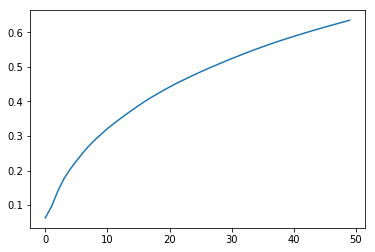

In [28]:
svd=TruncatedSVD(n_components=50,random_state=10)
X_transform=svd.fit_transform(bag_words)

CDF=np.cumsum(svd.explained_variance_ratio_)
plt.plot(CDF)
print(svd.explained_variance_ratio_.sum())

In [29]:
from sklearn.manifold import TSNE

model=TSNE(random_state=10)
transform=model.fit_transform(X_transform)


Text(0,0.5,'component_2')

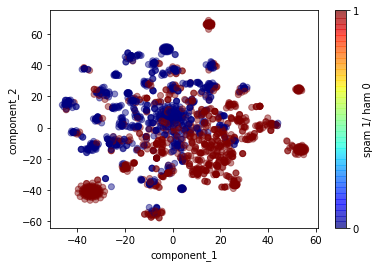

In [30]:
df_tsne=pd.DataFrame()
df_tsne['x']=transform[:,0]
df_tsne['y']=transform[:,1]
df_tsne['class']=df['CLASS'].values
plt.scatter(df_tsne.x,df_tsne.y,c=df_tsne['class'],cmap='jet',alpha=0.45)
plt.colorbar(label='spam 1/ ham 0', ticks=range(2))
plt.xlabel('component_1')
plt.ylabel('component_2')

The distance on the above figure shows how closely two docs are semantically. As we seen ham and spam comments are very similiar semantically.

Text(0.5,1,'ham')

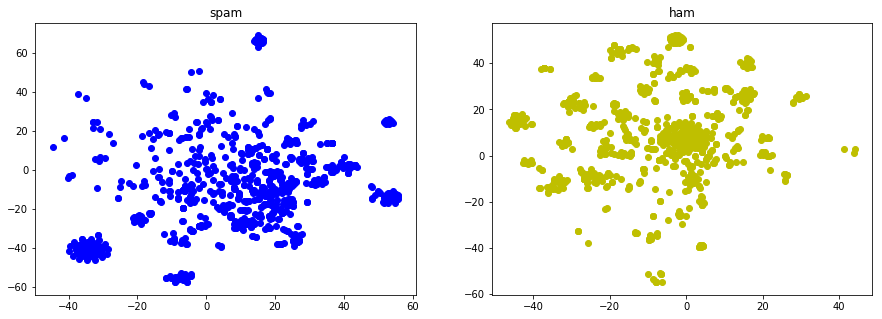

In [31]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(15,5))
ax1.scatter(df_tsne[df_tsne['class']==1].x,df_tsne[df_tsne['class']==1].y,c='b')
ax1.set_title('spam')
ax2.scatter(df_tsne[df_tsne['class']==0].x,df_tsne[df_tsne['class']==0].y,c='y')
ax2.set_title('ham')


### Next interesting quesition is: what are most important words in spam and ham group:

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(tokenizer=preprocess, min_df=10)
bag_words=vectorizer.fit_transform(content).toarray()

spam_bag_words=bag_words[df.CLASS==1]
spam_words=spam_bag_words.sum(axis=0)
idx = np.argsort(spam_words)[-10:]
top_10 = [word for word, num in vectorizer.vocabulary_.items() if num in idx]
print(top_10)

['subscrib', 'video', 'http', 'amp', 'like', 'br', 'check', 'pleas', 'youtub', 'channel']


In [33]:

ham_bag_words= bag_words[df.CLASS==0]
ham_words=ham_bag_words.sum(axis=0)
idx = np.argsort(ham_words)[-10:]
top_10 = [word for word, num in vectorizer.vocabulary_.items() if num in idx]
print(top_10)

['love', 'perri', 'billion', 'video', 'song', 'like', 'br', 'best', 'kati', 'view']


The most freq words in spam group relates to self-promoting videos with keywords like http, check and subscribe. The most freq words in ham group however are more relate to the song, some keywords relate to song's artist like kati perri. Some keywords describe the general feelings towards the song such as best, like, love.

In [34]:
# LDA analysis

from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 5
number_words = 10

lda = LDA(n_components=number_topics)
lda.fit(spam_bag_words)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)


/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topics found via LDA:

Topic #0:
check video youtub subscrib channel pleas guy go watch thank

Topic #1:
make new money work share http month home visit websit

Topic #2:
br quot remix song rihanna check like subscrib hit million

Topic #3:
http amp gt like pleas lt kati free awesom song

Topic #4:
music pleas like thank comment u would hey check get


In [35]:

lda = LDA(n_components=number_topics)
lda.fit(ham_bag_words)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Topics found via LDA:

Topic #0:
kati song perri music still lt eminem fuck like listen

Topic #1:
view video like billion song get watch peopl awesom old

Topic #2:
year shuffl time style psi like gangnam would lol back

Topic #3:
good wow go girl megan fox first comment part shit

Topic #4:
love song br shakira best beauti waka make much nice


## Machine learning

This section we explore different machine learning models for this classification problem.

1. Naive Bayes
2. Random Forest
3. Logistic Regression
4. SVM


In [36]:
# helper function to print out misclassification comments:

def miss_classification_print (pred_labels, test_labels, df):
    """this function is to print out some misclassificaiton examples"""
    """you need to provide: predict labels, the real labels, and the dataframe of the data"""
    
    ham=[]
    spam=[]
    for i in np.arange(df.shape[0]):
        if pred_labels[i] != test_labels[i]:
            if pred_labels [i] == 1:
                ham.append(df.iloc[i].CONTENT)
            if pred_labels [i]== 0:
                spam.append(df.iloc[i].CONTENT)
    print('ham messages that are misclassified as spam \n')
    for i in ham:
        print(i)
    print('\n')
    print('\n')
    print('spam messages that are misclassified as ham \n')
    for i in spam:
        print(i)


In [37]:
# let's try naive bayes as baseline.

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

X=df.drop(['CLASS'],axis=1)
y=df['CLASS']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=10)

# create bag of words
vec=TfidfVectorizer(min_df=3)
tfidf=vec.fit_transform(X_train['CONTENT'])
print("number of words before preprocessing: ", len(vec.get_feature_names()))

# define estimator
clf=MultinomialNB()

# define hypoparameters to tune
params_nb={'alpha': [0.00001,0.001, 0.1, 1, 10]}

grid_nb=GridSearchCV(estimator=clf, param_grid=params_nb,scoring='accuracy',cv=10,n_jobs=-1)
grid_nb.fit(tfidf,y_train)
model_nb=grid_nb.best_estimator_
print("best alpha: ", grid_nb.best_params_)
print("best CV accuracy: ",grid_nb.best_score_)

X_test_tfidf=vec.transform(X_test['CONTENT'])
print("the confusion matrix: \n", confusion_matrix(y_test,model_nb.predict(X_test_tfidf)))
print("the accuracy score is ", accuracy_score(y_test,model_nb.predict(X_test_tfidf)))


number of words before preprocessing:  863
best alpha:  {'alpha': 0.1}
best CV accuracy:  0.9202453987730062
the confusion matrix: 
 [[218  34]
 [ 12 225]]
the accuracy score is  0.9059304703476483


In [38]:
miss_classification_print(model_nb.predict(X_test_tfidf),y_test,X_test)

ham messages that are misclassified as spam 

This song is about Rape and Cheating     <br /><br /><br /><br /><br /><br /><br /><br /><br /><br />Basically.....﻿
:3﻿
this song always gives me chills! :)
I want to see Shakira, not football :)
Looooved ﻿
cooooooooooooolllllllllll﻿
#2012bitches﻿
ILOVETHISSONG﻿
This song means so much to me thank you  soooooooooooooooooooooooooooooooooooooooo much:-) Xxx﻿
Awsome<br />﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
:)
I found out this song now﻿
:D﻿
Gooooood﻿
Loves it﻿
"....because I AM a champion...and you are going to hear me roar!"   Today I AM my own champion  Today I AM a champion for the Creator  Today I AM doing positive in my world Today I AM blessing and healing all around me Today I AM successful and  creating success  ﻿
On 0:02 you can see the camera man on his glasses....﻿
selfie alert﻿
What&#39;s with the guys jacket? 1 sleeve and 

from the confusion matrix, we can see 40 comments are miss-classified as spam where they are ham. We don't want this situation to happen. Actually we would rather the model to have more false negative than false positive.

No preprocessing is performed since I tested that preprocessing steps such as stop words removal or stemming hurt the performance. The accuracy score using pre-processed data is 0.83.

(I tested preprocessing steps: stop word removal, stem, min_df, punctuation removal, stem individually and found that both stem and punctuation removal hurt the performance of models, including naive bayes, random forest, and logistic regression)

Reference: Spam Filtering: How the dimensionality reduction affects the accuracy of the naive bayes classification. This paper explores why feature dimension reduction hurts the performance

In [39]:
# random forest

from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=10)

params_rf={'n_estimators': [100, 200, 300, 400, 500]}

grid_rf=GridSearchCV(estimator=rf, param_grid=params_rf,scoring='accuracy',cv=5,n_jobs=-1)
grid_rf.fit(tfidf,y_train)
model_rf=grid_rf.best_estimator_
print("best alpha: ", grid_rf.best_params_)
print("best CV accuracy: ",grid_rf.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_rf.predict(X_test_tfidf)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_rf.predict(X_test_tfidf)))

best alpha:  {'n_estimators': 100}
best CV accuracy:  0.956373551465576
the confusion matrix on test data: 
 [[244   8]
 [ 16 221]]
the accuracy score on test data is  0.950920245398773


In [40]:
miss_classification_print(model_rf.predict(X_test_tfidf),y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
The little PSY is suffering Brain Tumor and only has 6 more months to live.  Please pray to him and the best lucks.﻿
"....because I AM a champion...and you are going to hear me roar!"   Today I AM my own champion  Today I AM a champion for the Creator  Today I AM doing positive in my world Today I AM blessing and healing all around me Today I AM successful and  creating success  ﻿
My honest opinion. it is a very mediocre song. Nothing unique or special  about her music, lyrics or voice. Nothing memorable like Billie Jean or  Beat It. Before her millions of fans reply with hate comments, i know this  is a democracy and people are free to see what they want. But then do not I  have the right

In [41]:
# logistic regression
# Grid search to tune hypoparameters

from sklearn.linear_model import LogisticRegression

lg=LogisticRegression(random_state=10)

params_lg={'C': [0.1, 1, 10, 50, 100]}

grid_lg=GridSearchCV(estimator=lg, param_grid=params_lg,scoring='accuracy',cv=5,n_jobs=-1)
grid_lg.fit(tfidf,y_train)
model_lg=grid_lg.best_estimator_
print("best alpha: ", grid_lg.best_params_)
print("best CV accuracy: ",grid_lg.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_lg.predict(X_test_tfidf)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_lg.predict(X_test_tfidf)))

best alpha:  {'C': 50}
best CV accuracy:  0.9461486025903204
the confusion matrix on test data: 
 [[241  11]
 [ 13 224]]
the accuracy score on test data is  0.950920245398773


In [42]:
miss_classification_print(model_lg.predict(X_test_tfidf),y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
I remember when everyone was obsessed with Gangnam Style 😗﻿
I found out this song now﻿
Her voice sounds weird and plus she&#39;s cute for a blonde﻿
Loves it﻿
On 0:02 you can see the camera man on his glasses....﻿
I do not even watch it anymore i just come here to check on 2 Billion or not﻿
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part﻿
Thumbs up if you&#39;re watching in 2015﻿
Why do I feel like as if Gangnam style copied their song from this?!﻿




spam messages that are misclassified as ham 

  Haha , Miley Cyrus has done it once again  Today someone leeched a porno video with her on a celeb site   I believe the website link is : miley-celeb-news.co.

In [43]:
# bag of words will create a lot of features and we know that SVM works good with high dimensions. 

from sklearn.svm import SVC

svc=SVC()

params_svc={'C': [0.001, 0.1, 1, 10],
            'kernel':['linear', 'poly', 'rbf']}

grid_svc=GridSearchCV(estimator=svc, param_grid=params_svc,scoring='accuracy',cv=5,n_jobs=-1)
grid_svc.fit(tfidf,y_train)
model_svc=grid_svc.best_estimator_
print("best alpha: ", grid_svc.best_params_)
print("best CV accuracy: ",grid_svc.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_svc.predict(X_test_tfidf)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_svc.predict(X_test_tfidf)))

best alpha:  {'kernel': 'linear', 'C': 1}
best CV accuracy:  0.950920245398773
the confusion matrix on test data: 
 [[246   6]
 [ 12 225]]
the accuracy score on test data is  0.9631901840490797


In [44]:
miss_classification_print(model_lg.predict(X_test_tfidf),y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
I remember when everyone was obsessed with Gangnam Style 😗﻿
I found out this song now﻿
Her voice sounds weird and plus she&#39;s cute for a blonde﻿
Loves it﻿
On 0:02 you can see the camera man on his glasses....﻿
I do not even watch it anymore i just come here to check on 2 Billion or not﻿
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part﻿
Thumbs up if you&#39;re watching in 2015﻿
Why do I feel like as if Gangnam style copied their song from this?!﻿




spam messages that are misclassified as ham 

  Haha , Miley Cyrus has done it once again  Today someone leeched a porno video with her on a celeb site   I believe the website link is : miley-celeb-news.co.

Generally speaking ways to improve model accuracy are:

 1. tune your classifier (adjusting the classifier's tunable paramaters);
 2. apply some sort of classifier combination technique (eg, ensembling, boosting, bagging); 
 3. look at the data fed to the classifier--either add more data, improve your basic parsing, or refine the features you select from the data.
 
In the last section we looked at option 1 and 2, where we tune each model parameters and tried ensemble method such as random forest. In the next section, we will explore adding more features and try ensemble methods to further improve model accuracy.

## Machine leanring -- more complex model

In [45]:
df.head()

,COMMENT_ID,AUTHOR,CONTENT,CLASS,song,length,URL,capital,user_isEnglish,Thursday
DATE,,,,,,,,,,
2013-11-07 06:20:48,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,Psy,56,False,0.017857,True,True
2013-11-07 12:37:15,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,Hey guys check out my new channel and our firs...,1,Psy,167,False,0.119760,True,True
2013-11-08 17:34:21,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,just for test I have to say murdev.com,1,Psy,38,False,0.026316,True,False
2013-11-09 08:28:43,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,Psy,48,False,0.000000,True,False
2013-11-10 16:05:38,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,watch?v=vtaRGgvGtWQ Check this out .﻿,1,Psy,39,True,0.153846,True,False


### first approah: concatenate bag of words with features we explore in the EDA that differentiate two groups:
1. comment length
2. the percentage of capital words
3. whether the comment is made on Thursday

In [46]:
from sklearn.preprocessing import MinMaxScaler

X_train['URL']=X_train['URL'].astype(int)
X_train['Thursday']=X_train['Thursday'].astype(int)
features=X_train[['URL','length','capital','Thursday']]
scaler=MinMaxScaler()
features_norm=scaler.fit_transform(features)

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [47]:
tfidf_dense=tfidf.toarray()
feature_new=np.concatenate((tfidf_dense,features_norm),axis=1)

In [48]:
# calculate new feature matrix for test data.

X_test['URL']=X_test['URL'].astype(int)
X_test['Thursday']=X_test['Thursday'].astype(int)
features_test=X_test[['URL','length','capital','Thursday']]
scaler_test=MinMaxScaler()
features_norm_test=scaler_test.fit_transform(features_test)
X_test_feature=np.concatenate((X_test_tfidf.toarray(),features_norm_test),axis=1)


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [49]:


svc=SVC()

params_svc={'C': [0.001, 0.1, 1, 10],
            'kernel':['linear', 'poly', 'rbf']}

grid_svc=GridSearchCV(estimator=svc, param_grid=params_svc,scoring='accuracy',cv=5,n_jobs=-1)
grid_svc.fit(feature_new,y_train)
model_svc_concat=grid_svc.best_estimator_
print("best alpha: ", grid_svc.best_params_)
print("best CV accuracy: ",grid_svc.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_svc_concat.predict(X_test_feature)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_svc_concat.predict(X_test_feature)))

best alpha:  {'kernel': 'linear', 'C': 1}
best CV accuracy:  0.9475119291070211
the confusion matrix on test data: 
 [[238  14]
 [  8 229]]
the accuracy score on test data is  0.9550102249488752


In [50]:
miss_classification_print(model_svc_concat.predict(X_test_feature),y_test,X_test)

ham messages that are misclassified as spam 

This song is about Rape and Cheating     <br /><br /><br /><br /><br /><br /><br /><br /><br /><br />Basically.....﻿
she is a fool. this is a foolish video. the lyrics are all about her and  how great she is. she is arrogant, obviously. but the thing is that there  are a lot of idiots.. look how many hits this garnered. the young stupid  girls who listen to her are numbering in the millions i guess. this video  is a piece of trash. why would anyone ever like it or listen to it? because  these stupid little girls have idiots for fathers and mothers.. and so they  are going to turn into idiots also.. just like this stupid singer. ﻿
C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
sorry to all my haters<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />for party rock en﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;

In [51]:


lg=LogisticRegression(random_state=10)

params_lg={'C': [0.1, 1, 10, 50, 100]}

grid_lg=GridSearchCV(estimator=lg, param_grid=params_lg,scoring='accuracy',cv=5,n_jobs=-1)
grid_lg.fit(feature_new,y_train)
model_lg_concat=grid_lg.best_estimator_
print("best alpha: ", grid_lg.best_params_)
print("best CV accuracy: ",grid_lg.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_lg_concat.predict(X_test_feature)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_lg_concat.predict(X_test_feature)))

best alpha:  {'C': 50}
best CV accuracy:  0.9522835719154737
the confusion matrix on test data: 
 [[233  19]
 [  7 230]]
the accuracy score on test data is  0.9468302658486708


In [52]:
miss_classification_print(model_lg_concat.predict(X_test_feature),y_test,X_test)

ham messages that are misclassified as spam 

This song is about Rape and Cheating     <br /><br /><br /><br /><br /><br /><br /><br /><br /><br />Basically.....﻿
she is a fool. this is a foolish video. the lyrics are all about her and  how great she is. she is arrogant, obviously. but the thing is that there  are a lot of idiots.. look how many hits this garnered. the young stupid  girls who listen to her are numbering in the millions i guess. this video  is a piece of trash. why would anyone ever like it or listen to it? because  these stupid little girls have idiots for fathers and mothers.. and so they  are going to turn into idiots also.. just like this stupid singer. ﻿
I started hating Katy Perry after finding out that she stole all of the  ideas on her videos  from an old comic book. Yet, her music is catchy. ﻿
C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
sorry to all my haters<br /><br /><br /><br /><br /><br />

In [53]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier(max_depth=4,random_state=10)

adb=AdaBoostClassifier(base_estimator=dt,random_state=10)

params_adb={'n_estimators': [50, 100, 200],
          'learning_rate': [0.1, 1, 10]}

grid_adb=GridSearchCV(estimator=adb, param_grid=params_adb,scoring='accuracy',cv=5,n_jobs=-1)
grid_adb.fit(feature_new,y_train)
model_adb_concat=grid_adb.best_estimator_
print("best alpha: ", grid_adb.best_params_)
print("best CV accuracy: ",grid_adb.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_adb_concat.predict(X_test_feature)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_adb_concat.predict(X_test_feature)))


best alpha:  {'n_estimators': 100, 'learning_rate': 1}
best CV accuracy:  0.9379686434901159
the confusion matrix on test data: 
 [[229  23]
 [ 14 223]]
the accuracy score on test data is  0.9243353783231084


In [54]:
print(feature_new.shape)
model_adb_concat.feature_importances_.argsort()

(1467, 867)


array([  0, 831, 515, 517, 518, 519, 520, 521, 830, 523, 524, 525, 526,
       527, 528, 531, 532, 533, 534, 535, 513, 537, 512, 832, 485, 486,
       487, 488, 489, 490, 492, 493, 494, 495, 496, 497, 499, 833, 502,
       503, 504, 505, 507, 510, 538, 539, 540, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 576, 577, 578, 580, 581, 582, 583, 584,
       585, 565, 564, 563, 562, 541, 542, 543, 544, 545, 546, 547, 549,
       550, 484, 551, 553, 828, 555, 556, 557, 558, 559, 560, 561, 552,
       483, 482, 834, 408, 409, 411, 412, 413, 415, 416, 417, 418, 420,
       421, 840, 423, 839, 425, 426, 838, 428, 429, 407, 811, 405, 403,
       378, 379, 381, 382, 383, 384, 386, 387, 389, 430, 390, 392, 393,
       394, 395, 396, 397, 398, 399, 401, 391, 587, 431, 837, 459, 460,
       461, 462, 463, 464, 465, 466, 467, 468, 835, 470, 471, 472, 473,
       475, 476, 479, 480, 458, 457, 456, 455, 434, 435, 436, 437, 439,
       440, 836, 442, 443, 432, 444, 446, 447, 448, 449, 450, 45

It's seen that concatenate bag of words with other features don't improve the accuracy. And it's seen that length of the comment and whether it contains URL are placed as more important features.

### second approach: use the probability from the models using bag of words as new features and concat it with features:
1. wheter it contains URL
2. comment length
3. the percentage of capital words
4. whether the comment is made on Thursday

In [55]:
X_prob_nb=model_nb.predict_proba(tfidf)
X_prob_rf=model_rf.predict_proba(tfidf)
X_prob_lg=model_lg.predict_proba(tfidf)


X_prob_nb=X_prob_nb[:,1].reshape(1467,1)
X_prob_rf=X_prob_rf[:,1].reshape(1467,1)
X_prob_lg=X_prob_lg[:,1].reshape(1467,1)

X_feature_prob=np.concatenate((features_norm,X_prob_nb,X_prob_rf,X_prob_lg),axis=1)


X_prob_nb_test=model_nb.predict_proba(X_test_tfidf)[:,1].reshape(489,1)
X_prob_rf_test=model_rf.predict_proba(X_test_tfidf)[:,1].reshape(489,1)
X_prob_lg_test=model_lg.predict_proba(X_test_tfidf)[:,1].reshape(489,1)

X_test_prob=np.concatenate((features_norm_test,X_prob_nb_test,X_prob_rf_test,X_prob_lg_test),axis=1)

In [56]:


lg=LogisticRegression(random_state=10)

params_lg={'C': [0.1, 1, 10, 50, 100]}

grid_lg=GridSearchCV(estimator=lg, param_grid=params_lg,scoring='accuracy',cv=5,n_jobs=-1)
grid_lg.fit(X_feature_prob,y_train)
model_prob_lg=grid_lg.best_estimator_
print("best alpha: ", grid_lg.best_params_)
print("best CV accuracy: ",grid_lg.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_prob_lg.predict(X_test_prob)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_prob_lg.predict(X_test_prob)))

best alpha:  {'C': 1}
best CV accuracy:  0.9986366734832992
the confusion matrix on test data: 
 [[243   9]
 [  9 228]]
the accuracy score on test data is  0.9631901840490797


In [57]:
miss_classification_print(model_prob_lg.predict(X_test_prob),y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
I found out this song now﻿
Loves it﻿
On 0:02 you can see the camera man on his glasses....﻿
What&#39;s with the guys jacket? 1 sleeve and a sleeveless arm﻿
I do not even watch it anymore i just come here to check on 2 Billion or not﻿
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part﻿
Thumbs up if you&#39;re watching in 2015﻿




spam messages that are misclassified as ham 

I love katy fashions tiger, care to visit my blog sinar jahitan  I also have the tiger collections tqvm﻿
Message :   GTA V  $20  FIFA 14 $15  PS4  $200  Galaxy S4 mini $250  Ipad 4   $200  visit the site hh.nl
I am so awesome and smart!!! Sucscribe to me!﻿
I&#39;m A SUBSCRIBER﻿
 I reall

As we see the validation score on training set is higher than testing set, which means the model tends to overfit the training data. We might need more training data to train such a complex model.

### Third approach: reduce the dimensionality of bag of words (using PCA or SVD) and combine with these features:

1. wheter it contains URL
2. comment length
3. the percentage of capital words
4. whether the comment is made on Thursday

0.9484107032010575


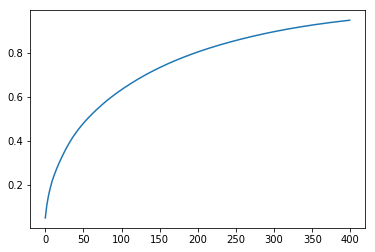

In [58]:
svd=TruncatedSVD(n_components=400,random_state=10)
X_transform=svd.fit_transform(tfidf)

CDF=np.cumsum(svd.explained_variance_ratio_)
plt.plot(CDF)
print(svd.explained_variance_ratio_.sum())

We select 350 components thus to retain 94.8% of the variance in the training data.

In [59]:
X_reduced_features=np.concatenate((features_norm,X_transform),axis=1)
X_reduced_test_features=np.concatenate((features_norm_test,svd.transform(X_test_tfidf)),axis=1)

In [60]:

lg=LogisticRegression(random_state=10)

params_lg={'C': [10, 50, 100]}

grid_lg=GridSearchCV(estimator=lg, param_grid=params_lg,scoring='accuracy',cv=5,n_jobs=-1)
grid_lg.fit(X_reduced_features,y_train)
model_reduce_lg=grid_lg.best_estimator_
print("best alpha: ", grid_lg.best_params_)
print("best CV accuracy: ",grid_lg.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_reduce_lg.predict(X_reduced_test_features)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_reduce_lg.predict(X_reduced_test_features)))

best alpha:  {'C': 50}
best CV accuracy:  0.9556918882072256
the confusion matrix on test data: 
 [[234  18]
 [  6 231]]
the accuracy score on test data is  0.950920245398773


In [61]:
svc=SVC()

params_svc={'C': [0.001, 0.1, 1, 10],
            'kernel':['linear', 'poly', 'rbf']}

grid_svc=GridSearchCV(estimator=svc, param_grid=params_svc,scoring='accuracy',cv=5,n_jobs=-1)
grid_svc.fit(X_reduced_features,y_train)
model_svc_reduce=grid_svc.best_estimator_
print("best alpha: ", grid_svc.best_params_)
print("best CV accuracy: ",grid_svc.best_score_)

print("the confusion matrix on test data: \n", confusion_matrix(y_test,model_svc_reduce.predict(X_reduced_test_features)))
print("the accuracy score on test data is ", accuracy_score(y_test,model_svc_reduce.predict(X_reduced_test_features)))

best alpha:  {'kernel': 'linear', 'C': 1}
best CV accuracy:  0.9502385821404227
the confusion matrix on test data: 
 [[238  14]
 [  7 230]]
the accuracy score on test data is  0.9570552147239264


In [62]:
miss_classification_print(model_prob_lg.predict(X_test_prob),y_test,X_test)

ham messages that are misclassified as spam 

C'mon Katy you are so close to 14,000,000 subscribers...come up with  another hit like this and it will happen﻿
If you are a person that loves real music you should listen to &quot;Cruz Supat&quot;<br />He is awesome as fuck!!! Just as eminem used to be.﻿
I found out this song now﻿
Loves it﻿
On 0:02 you can see the camera man on his glasses....﻿
What&#39;s with the guys jacket? 1 sleeve and a sleeveless arm﻿
I do not even watch it anymore i just come here to check on 2 Billion or not﻿
<a href="http://www.youtube.com/watch?v=KQ6zr6kCPj8&amp;t=2m19s">2:19</a> best part﻿
Thumbs up if you&#39;re watching in 2015﻿




spam messages that are misclassified as ham 

I love katy fashions tiger, care to visit my blog sinar jahitan  I also have the tiger collections tqvm﻿
Message :   GTA V  $20  FIFA 14 $15  PS4  $200  Galaxy S4 mini $250  Ipad 4   $200  visit the site hh.nl
I am so awesome and smart!!! Sucscribe to me!﻿
I&#39;m A SUBSCRIBER﻿
 I reall